<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [1]:
# from deepul.hw1_helper import *

%reload_ext autoreload
%autoreload 2

import os
import sys
module_paths = [os.path.abspath(os.path.join('../..')),
                os.path.abspath(os.path.join('../../..'))]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


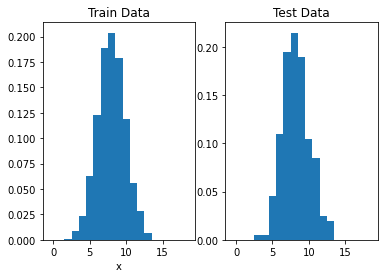

Dataset 2


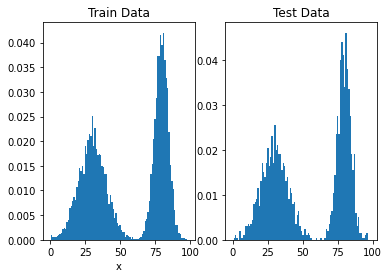

In [3]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [2]:
# imports
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
def calc_loss(model, data_loader, class_conditioned=False):
    model.eval()
    total_loss = 0
    for x in data_loader:
        if class_conditioned:
            x, y = x
            x = x.to(device)
            y = y.to(device)
            loss = model.loss(x, y)
        else:
            x = x.to(device)
            loss = model.loss(x)
        total_loss += loss.item()
    return total_loss / len(data_loader)

def train(model, optimizer, train_loader, test_loader, num_epochs, class_conditioned=False):
    train_loss = []
    test_loss = []
    
    test_loss.append(calc_loss(model, test_loader))
    
    for epoch in range(num_epochs):
        model.train()
        for x in train_loader:
            optimizer.zero_grad()
            if class_conditioned:
                x, y = x
                x = x.to(device)
                y = y.to(device)
                loss = model.loss(x, y)
            else:
                x = x.to(device)
                loss = model.loss(x)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # train_loss.append(calc_loss(model, train_loader))
        test_loss.append(calc_loss(model, test_loader, class_conditioned))
    return train_loss, test_loss

In [5]:
class Histogram(nn.Module):
    def __init__(self, d) -> None:
        super().__init__()
        self.d = d
        self.theta = nn.Parameter(torch.zeros((d,)), requires_grad=True)

    def forward(self, x):
        log_denum = torch.logsumexp(self.theta, dim=0)  
        log_nom = self.theta[x]
        log_probs = log_nom - log_denum
        return log_probs.mean()

    def probability(self):
        with torch.no_grad():
            return torch.softmax(self.theta, dim=0).detach().cpu().numpy()

    def loss(self, x):
        return -self.forward(x)

In [6]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  # YOUR CODE HERE
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
  model = Histogram(d).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.035)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 10)
  return np.array(train_loss), np.array(test_loss), model.probability()

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.0062


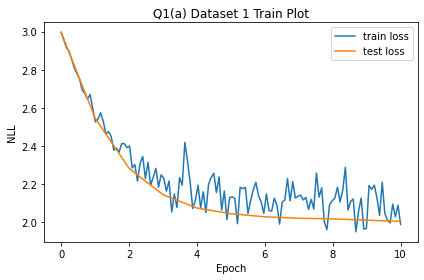

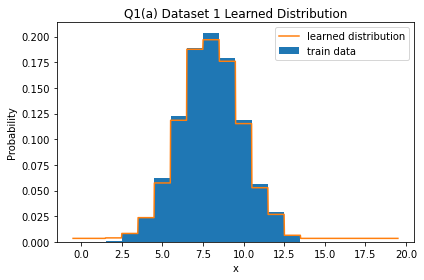

In [40]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 4.0388


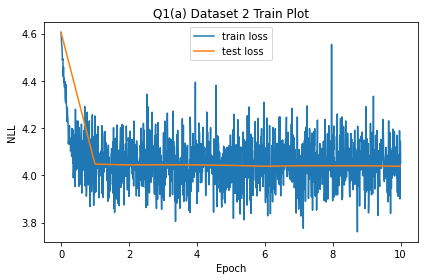

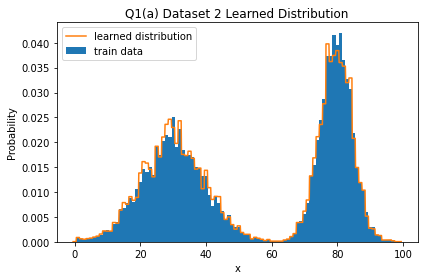

In [41]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [6]:
class LogisticMixture(nn.Module):
    def __init__(self, d, mix_n=4) -> None:
        super().__init__()
        self.d = d
        self.mix_n = mix_n

        step = d / mix_n
        self.means = nn.Parameter(torch.arange(step/2, d, step), requires_grad=True)
        self.log_scale = nn.Parameter(torch.zeros((mix_n,)), requires_grad=True)
        self.pi_logits = nn.Parameter(torch.zeros(mix_n), requires_grad=True)


    def forward(self, x, return_mean=True):
        x = x.float().view(-1, 1)
        s = torch.exp(-self.log_scale)
        arg1 = (x + 0.5 - self.means) * s
        arg2 = (x - 0.5 - self.means) * s
        sig1 = torch.where(x == self.d - 1, 1, torch.sigmoid(arg1))
        sig2 = torch.where(x == 0, 0, torch.sigmoid(arg2))
        delta_sig = sig1 - sig2
        # without the following line, everything becomes NaN!
        delta_sig = torch.clamp(delta_sig, min=1e-10)
        log_delta_sig = torch.log(delta_sig)
        log_pi = F.log_softmax(self.pi_logits, dim=0)
        log_mixtures = log_pi + log_delta_sig
        log_probs = torch.logsumexp(log_mixtures, dim=1)
        if return_mean:
            return log_probs.mean()
        return log_probs

    
    def probability(self):
        with torch.no_grad():
            return self(torch.arange(self.d, device=device), return_mean=False).exp().detach().cpu().numpy()

    def loss(self, x):
        return -self.forward(x)

In [7]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
  model = LogisticMixture(d, mix_n=100).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.035)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 10)
  return np.array(train_loss), np.array(test_loss), model.probability()

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 1.9936


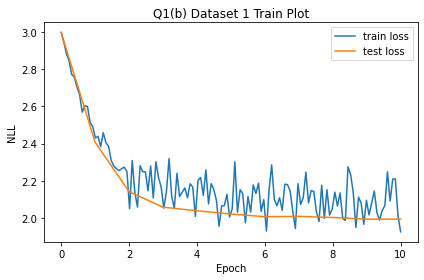

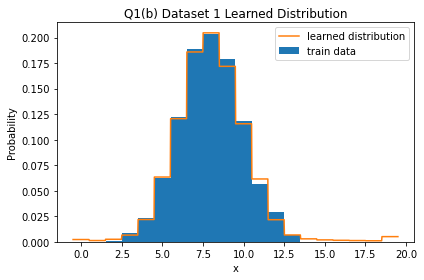

In [44]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 4.0362


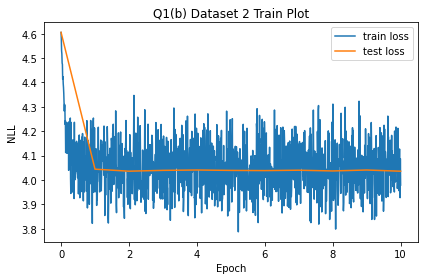

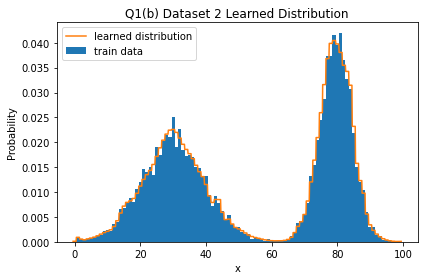

In [45]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


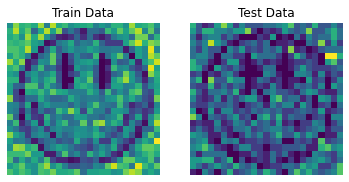

Dataset 2


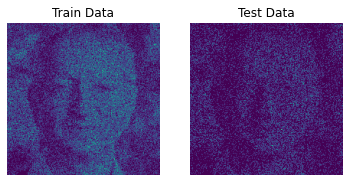

In [17]:
visualize_q2a_data(dset_type=1, local=True)
visualize_q2a_data(dset_type=2, local=True)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [8]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones_like(self.weight))

    def forward(self, x):
        return F.linear(x, self.mask * self.weight, self.bias)

    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.T))

In [9]:
from more_itertools import pairwise

class MADE(nn.Module):
    def __init__(self, shape_in, d, hidden_layer_sizes, order=None, one_hot=True) -> None:
        super().__init__()
        self.d = d
        self.shape_in = shape_in
        self.n_in = np.prod(shape_in)
        self.hidden_layer_sizes = hidden_layer_sizes
        self.one_hot = one_hot
        self.order = order if order is not None else np.arange(self.n_in)
        self.order_inverse = np.argsort(self.order)

        layers = []
        layer_sizes = [self.n_in * d if one_hot else self.n_in] + hidden_layer_sizes + [self.n_in * d]
        for in_size, out_size in pairwise(layer_sizes):
            layers.append(MaskedLinear(in_size, out_size))
            layers.append(nn.ReLU())
        layers.pop()
        self.masked_mlp = nn.Sequential(*layers)
        self.create_masks()

    def create_masks(self):
        masks = []
        last_m = self.order
        for size in self.hidden_layer_sizes:
            m = np.random.randint(last_m.min(), self.n_in-1, size=size)
            mask = last_m.reshape(-1, 1) <= m
            masks.append(mask)
            last_m = m
        mask = last_m.reshape(-1, 1) < self.order
        # mask should be repeated for each of the d outputs
        mask = np.concatenate([mask] * self.d, axis=1)
        masks.append(mask)
        if self.one_hot:
            masks[0] = np.repeat(masks[0], self.d, axis=0)
        for layer, mask in zip(filter(lambda layer: isinstance(layer, MaskedLinear), self.masked_mlp.modules()), masks):
            layer.set_mask(mask)
    
    def forward(self, x):
        if self.one_hot:
            x = F.one_hot(x.long(), self.d).float()
            x = x.view(-1, self.n_in * self.d)
        else:
            x = x.float().view(-1, self.n_in)
        x = self.masked_mlp(x)
        return x.view(-1, self.d, self.n_in)

    def loss(self, x):
        return F.cross_entropy(self(x), x.long().view(-1, self.n_in))

    def sample(self, n):
        with torch.no_grad():
            x = torch.zeros(n, self.n_in, device=device)
            for i in range(self.n_in):
                logits = self(x)
                probs = F.softmax(logits[:, :, self.order_inverse[i]], dim=1)
                x[:, self.order_inverse[i]] = torch.multinomial(probs, 1).squeeze(1)
            return x.view(-1, *self.shape_in).cpu().numpy()

    # for this problem
    def get_2D_distribution(self):
        with torch.no_grad():
            x = np.zeros((self.d, self.d, 2))
            i, j = np.indices((self.d, self.d))
            x[:, :, 0] = i
            x[:, :, 1] = j
            x = torch.from_numpy(x.reshape(-1, 2)).to(device)
            # now x contains all possible 2D combinations
            logits = self(x) # (d*d, d, 2)
            log_probs = F.log_softmax(logits, dim=1).cpu().numpy()
            i, j = np.indices(x.shape)
            log_probs = log_probs[i, x.long(), j]
            return np.exp(log_probs.sum(-1)).reshape((self.d, self.d))

In [35]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  """ YOUR CODE HERE """
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
  model = MADE((2,), d, [100, 100, 100], one_hot=True).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 15)
  return np.array(train_loss), np.array(test_loss), model.get_2D_distribution()

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



(625, 2)
Final Test Loss: 3.1880


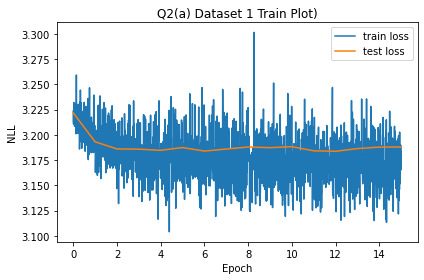

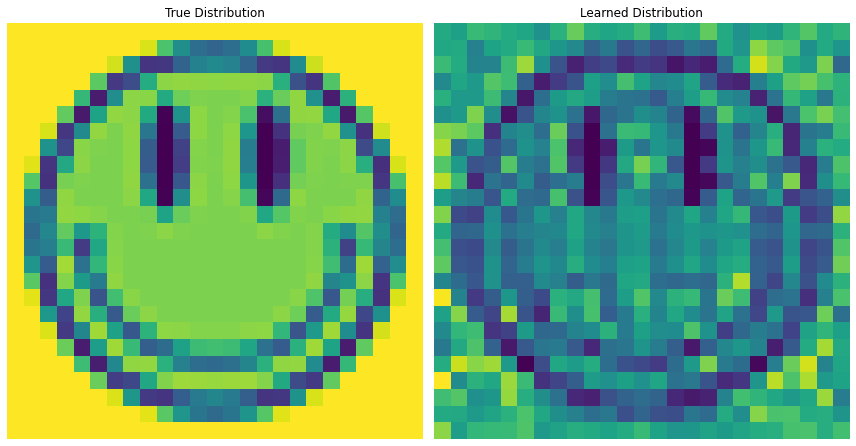

In [32]:
q2_save_results(1, 'a', q2_a, local=True)

(40000, 2)
Final Test Loss: 5.2824


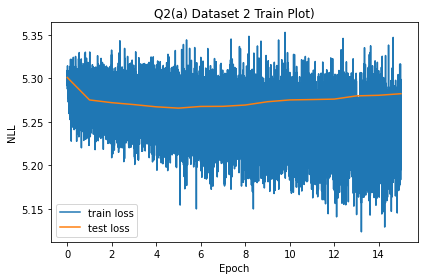

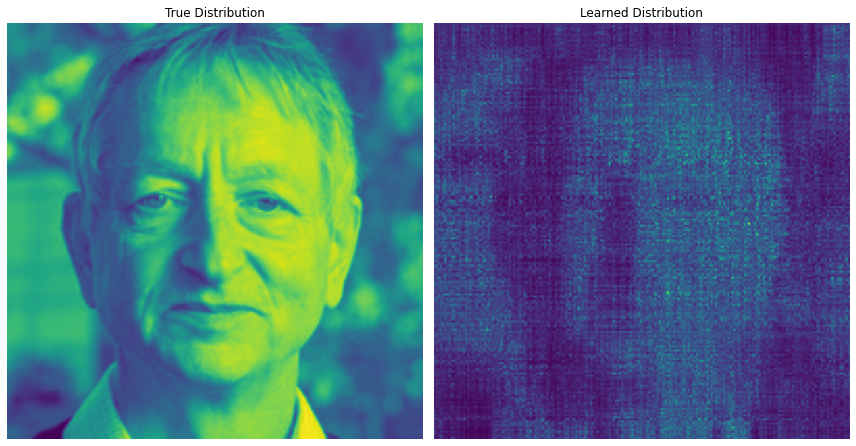

In [36]:
q2_save_results(2, 'a', q2_a, local=True)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

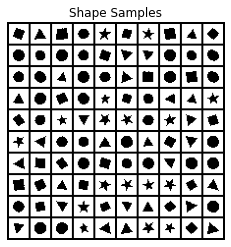

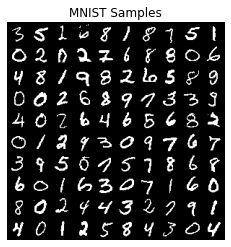

In [20]:
visualize_q2b_data(1, local=True)
visualize_q2b_data(2, local=True)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [53]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
  model = MADE(image_shape, 2, [256, 256, 256], one_hot=False).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 20)
  return np.array(train_loss), np.array(test_loss), model.sample(100)[..., np.newaxis]

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0864


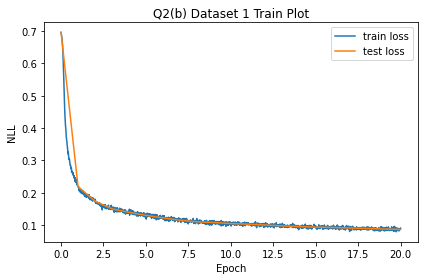

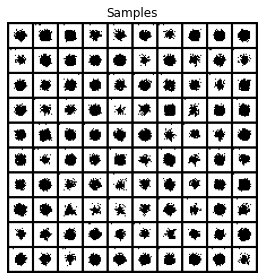

In [54]:
q2_save_results(1, 'b', q2_b, local=True)

Final Test Loss: 0.1385


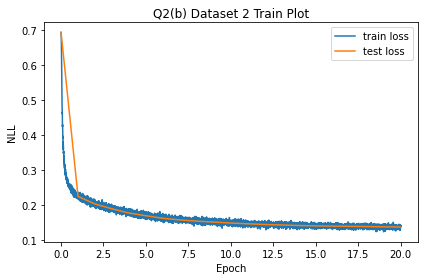

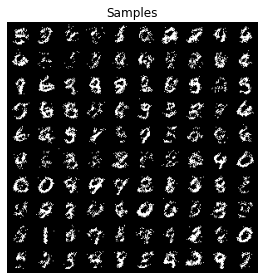

In [55]:
q2_save_results(2, 'b', q2_b, local=True)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [17]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, *args, mask_type=None, color_conditioned=False, num_classes=None, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in ['A', 'B'], 'mask_type must be A or B'
        self.mask_type = mask_type
        self.color_conditioned = color_conditioned
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.set_mask()
        self.num_classes = num_classes
        if num_classes:
            self.class_embedding = nn.Embedding(num_classes, self.in_channels)

    def set_mask(self):
        k = self.weight.size(2)
        self.mask[:, :, :k//2, :k//2] = 1
        self.mask[:, :, k//2, k//2:] = 1
        if self.color_conditioned:
            assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
            group_size = self.in_channels // 3
            if self.mask_type == 'A':
                self.mask[group_size:, :group_size, k//2, k//2] = 1
                self.mask[2*group_size:, group_size:2*group_size, k//2, k//2] = 1
            else:
                self.mask[:, :group_size, k//2, k//2] = 1
                self.mask[group_size:, group_size:2*group_size, k//2, k//2] = 1
                self.mask[2*group_size:, 2*group_size:, k//2, k//2] = 1
        elif self.mask_type == 'B':
            self.mask[:, :, k//2, k//2] = 1

    def forward(self, x, y=None):
        x = F.conv2d(x, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)
        if self.num_classes is not None and y is not None:
            return x + self.class_embedding(y).view(-1, self.in_channels, 1, 1)
        return x

In [18]:
class AutoRegressiveLayerNorm(nn.Module):
    def __init__(self, num_channels, color_conditioned=False) -> None:
        super().__init__()
        self.color_conditioned = color_conditioned
        if color_conditioned:
            assert num_channels % 3 == 0, 'num_channels must be divisible by 3'
            self.norm = nn.GroupNorm(3, num_channels)
        else:
            self.norm = nn.GroupNorm(1, num_channels)
    def forward(self, x):
        return self.norm(x)

In [19]:
class ResidualBottleNeck(nn.Module):
    def __init__(self, num_filters=64, kernel_size=7, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
                MaskedConv2d(num_filters, num_filters//2, 1, mask_type='B', **kwargs),
                nn.ReLU(),
                MaskedConv2d(num_filters//2, num_filters//2, kernel_size, padding=kernel_size//2, mask_type='B', **kwargs),
                nn.ReLU(),
                MaskedConv2d(num_filters//2, num_filters, 1, mask_type='B', **kwargs),
            ])
        
    def forward(self, x, y=None):
        for layer in self.layers:
            if isinstance(layer, MaskedConv2d):
                out = layer(x, y)
            else:
                out = layer(x)
        return out + x

In [20]:
class PixelCNN(nn.Module):
    def __init__(self, image_shape, num_in_channel, d, num_layers=10,
                num_filters=64, kernel_size=7, color_conditioned=False, use_residual=False, num_classes=None):
        super().__init__()
        self.image_shape = image_shape
        self.num_in_channel = num_in_channel
        self.d = d  # number of different colors for each channel
        self.num_layers = num_layers
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.color_conditioned = color_conditioned
        self.num_classes = num_classes

        kwargs = {'color_conditioned':color_conditioned, 'num_classes':num_classes}

        layers = []

        type_A_block = MaskedConv2d(num_in_channel, num_filters, kernel_size, padding=kernel_size//2, mask_type='A', **kwargs)
        if use_residual:
            type_B_block = ResidualBottleNeck(num_filters, kernel_size, **kwargs)
        else:
            type_B_block = MaskedConv2d(num_filters, num_filters, kernel_size, padding=kernel_size//2, mask_type='B', **kwargs)
        norm = AutoRegressiveLayerNorm(num_filters, color_conditioned=color_conditioned)
        
        layers.append(type_A_block)
        layers.append(norm)
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):
            layers.append(type_B_block)
            layers.append(norm)
            layers.append(nn.ReLU())
        layers.append(MaskedConv2d(num_filters, num_filters, 1, mask_type='B', **kwargs))
        layers.append(nn.ReLU())
        layers.append(MaskedConv2d(num_filters, d * num_in_channel, 1, mask_type='B', **kwargs))    
        self.layers = nn.ModuleList(layers)


    def min_max_norm(self, x):
        """Min-max normalization to [-1, 1]"""
        return 2 * x / (self.d - 1) - 1


    def forward(self, x, y=None):
        x = x.view(-1, self.num_in_channel, *self.image_shape).float()
        x = self.min_max_norm(x)
        for layer in self.layers:
            if isinstance(layer, MaskedConv2d) or isinstance(layer, ResidualBottleNeck):
                x = layer(x, y)
            else:
                x = layer(x)
        return x.view(-1, self.num_in_channel, self.d, *self.image_shape).permute(0, 2, 1, 3, 4)


    def loss(self, x, y=None):
        x = x.view(-1, self.num_in_channel, *self.image_shape)
        logits = self.forward(x, y)
        return F.cross_entropy(logits, x.long())


    def sample(self, num_samples, y=None):
            with torch.no_grad():
                samples = torch.zeros(num_samples, self.num_in_channel, *self.image_shape, dtype=torch.long)
                if self.color_conditioned:
                    for i in range(self.image_shape[0]):
                        for j in range(self.image_shape[1]):
                            for c in range(self.num_in_channel):
                                logits = self.forward(samples, y)
                                probs = F.softmax(logits[:, :, c, i, j], dim=1)
                                samples[:, c, i, j] = torch.multinomial(probs, 1).squeeze()                            
                else:
                    for i in range(self.image_shape[0]):
                        for j in range(self.image_shape[1]):
                            logits = self.forward(samples, y)
                            probs = F.softmax(logits[:, :, :, i, j], dim=1)
                            samples[:, :, i, j] = torch.multinomial(probs.view(-1, self.d), 1).squeeze().view(-1, self.num_in_channel)
                return samples.permute(0, 2, 3, 1).cpu().numpy()

In [21]:
# test
image_shape = (2, 2)
# black and white image
x = torch.randint(0, 2, (10, *image_shape))
model = PixelCNN(image_shape, 1, 2, num_classes=10)
model.loss(x), model(x).shape, model.sample(10).shape

(tensor(0.6861, grad_fn=<NllLoss2DBackward0>),
 torch.Size([10, 2, 1, 2, 2]),
 (10, 2, 2, 1))

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
  model = PixelCNN(image_shape, 1, 2)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 20)
  return np.array(train_loss), np.array(test_loss), model.sample(100)

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



Final Test Loss: 0.0420


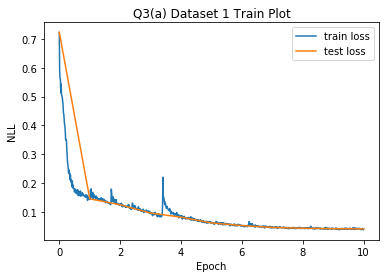

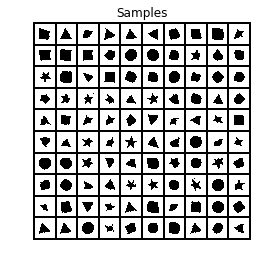

In [ ]:
q3a_save_results(1, q3_a)

In [ ]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

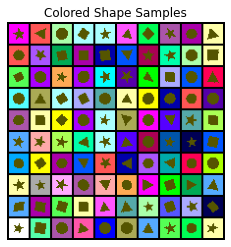

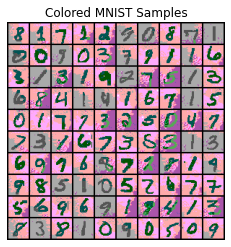

In [15]:
visualize_q3b_data(1, local=True)
visualize_q3b_data(2, local=True)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """
  H, W, C = image_shape
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
  model = PixelCNN((H, W), C, 4, color_conditioned=True, num_filters=120, use_residual=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 20)
  return np.array(train_loss), np.array(test_loss), model.sample(100)

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0444


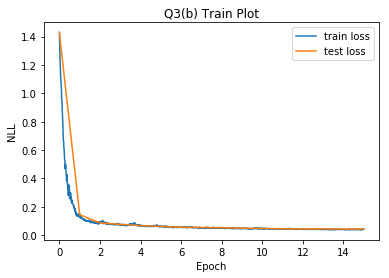

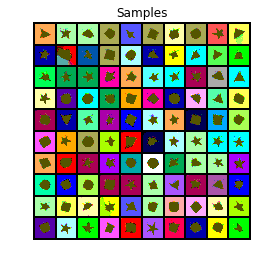

In [ ]:
q3bc_save_results(1, 'b', q3_b)

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """
  H, W, C = image_shape
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
  model = PixelCNN((H, W), C, 4, color_conditioned=True, num_filters=120, use_residual=True)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 20)
  return np.array(train_loss), np.array(test_loss), model.sample(100)

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Final Test Loss: 0.0236


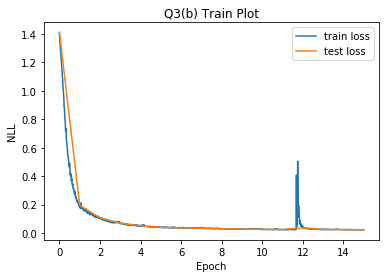

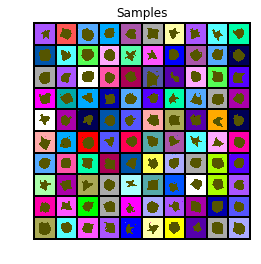

In [ ]:
q3bc_save_results(1, 'c', q3_c)

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$ th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """
  H, W = image_shape
  train_set = torch.utils.data.TensorDataset(train_data, train_labels)
  test_set = torch.utils.data.TensorDataset(test_data, test_labels)
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)
  model = PixelCNN((H, W), 1, 2, color_conditioned=False, num_filters=120, use_residual=True, num_classes=n_classes)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, test_loss = train(model, optimizer, train_loader, test_loader, 20)
  samples_labels = torch.arange(n_classes).repeat(100 // n_classes)
  return np.array(train_loss), np.array(test_loss), model.sample(100, samples_labels)

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



Final Test Loss: 0.0368


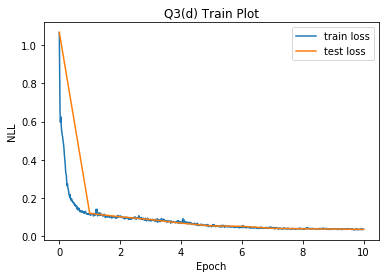

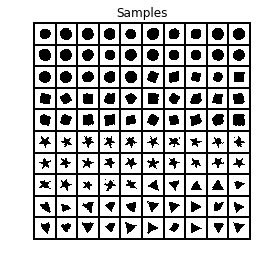

In [ ]:
q3d_save_results(1, q3_d)

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)